In [13]:
import utils
import Simple_LSTM

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms


from importlib import reload

import h5py

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import yaml

In [2]:
with open("SimpleLSTM.yaml", "r") as f:
  net_archi = yaml.load(f, Loader=yaml.FullLoader)
  
  print(net_archi)

{'SimpleLSTM1out_noDrop': {'input_size': 3467, 'hidden_size': 10, 'num_layers': 1, 'lstm_dropout': 0.0, 'linear_features': [2], 'linear_dropout': [], 'last_layer_activation': 'Softmax(dim=1)'}}


In [56]:
reload(utils)

transform = transforms.Compose(
    [transforms.ToTensor()
    ]
)
  
dataset = utils.MFCCDataset("../datasets/Aves-Mammalia.csv", 
                           "../mfcc", 
                           "gbifID", "class", 
                           one_hot_encode_labels=True,
                           transform=transform)

In [57]:
dataset[0]["mfcc"].shape

torch.Size([20, 3467])

In [58]:
test = DataLoader(dataset, batch_size=8)

In [59]:
out = next(iter(test))

out["mfcc"].shape

torch.Size([8, 20, 3467])

In [60]:
# Parameters
random_seed = 42

batch_size = 16
lr = 0.001
epochs = 5

net_name = "SimpleLSTM1out_noDrop"

In [61]:
test_percentage = .2
test_len = int((len(dataset) * test_percentage))
train_len = len(dataset) - test_len

train, test = random_split(dataset, [train_len, test_len], torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(train, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [62]:
len(train_loader.dataset), len(test_loader.dataset)

(1600, 400)

In [63]:
reload(Simple_LSTM)

net = Simple_LSTM.SimpleLSTM(net_archi[net_name])

net = utils.cuda_network(net)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = lr)

CUDA available: converting network to CUDA


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]


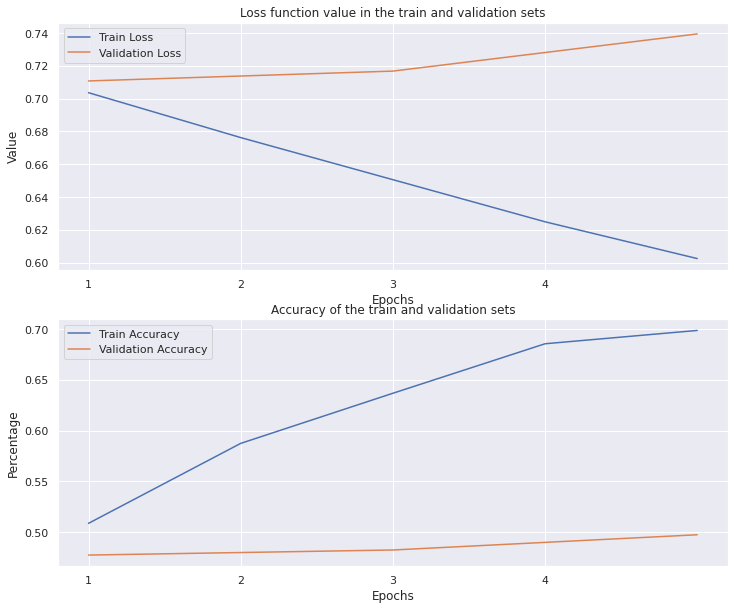

In [64]:
((train_loss, train_acc),
 (val_loss, val_acc)) = net.fit(epochs, train_loader, test_loader, criterion, optimizer,
                             log_file=net_name+".log", 
                             plot_file=net_name+".png", 
                             train_name=net_name)